In [1]:
import pandas as pd
# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


# feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from textblob import TextBlob

# gensim
import gensim
from gensim import corpora, models, similarities, matutils

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB


import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler, MinMaxScaler,MaxAbsScaler
import string


In [3]:
import re
from pymongo import MongoClient
# This connects us to the "tripAdvisor_london_restaurant" database, and the "collection" [think table] restaurant_reviews 
# in that database
client = MongoClient()
db = client.restaurant_gurugram
collection = db.restaurant_reviews

cursor = db.restaurant_reviews.find({}, {'_id':0,'id':0,'index':0})
df = pd.DataFrame(data=list(cursor))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8232 entries, 0 to 8231
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      8232 non-null   object 
 1   rating    8232 non-null   object 
 2   comments  8232 non-null   object 
 3   users     8232 non-null   object 
 4   summary   0 non-null      float64
 5   info      7491 non-null   object 
 6   loc       8232 non-null   object 
dtypes: float64(1), object(6)
memory usage: 450.3+ KB


In [4]:
df["name"] = df["name"].replace(r'([\d]+)\.','',regex=True)
df["sıralama"] = df["name"].str.extract('([\d]+)\. ', expand=False)
df = df.sort_values(by=["sıralama"])
df = df.drop(columns=["sıralama"]) # 24103
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8232 entries, 0 to 8231
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      8232 non-null   object 
 1   rating    8232 non-null   object 
 2   comments  8232 non-null   object 
 3   users     8232 non-null   object 
 4   summary   0 non-null      float64
 5   info      7491 non-null   object 
 6   loc       8232 non-null   object 
dtypes: float64(1), object(6)
memory usage: 514.5+ KB


In [5]:
df = df.drop_duplicates(subset =["name","rating","comments"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8212 entries, 0 to 8231
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      8212 non-null   object 
 1   rating    8212 non-null   object 
 2   comments  8212 non-null   object 
 3   users     8212 non-null   object 
 4   summary   0 non-null      float64
 5   info      7471 non-null   object 
 6   loc       8212 non-null   object 
dtypes: float64(1), object(6)
memory usage: 513.2+ KB


In [6]:

df.name.nunique()

252

In [7]:
df = df.reset_index()

val = df["loc"].to_list()

new =[]

for v in val:
    if(len(v)==2 or len(v)==1):
        new.append(str(v[0]))
    else:
        new.append(str(v))
df["loc"] = new

df.rating = df.rating.astype("int")
#df["street"] = df["loc"].apply(lambda x : x.split(",")[0])
#df["postCode"] = df["loc"].apply(lambda x :x.split(",")[-1])

#df["users"].nunique() # 19611 name

df["info"] = df["info"].fillna("")

In [8]:
df["loc"][132]

'Golf Course Road, Dlf-5, Sector 43 One Horizon Center, One Horizon Center, Plaza Level, Gurugram (Gurgaon) 122002 India'

In [9]:
df["info"] = df["info"].apply(lambda x: " ".join(x))

In [10]:
df = df.drop(columns=["index"])

df["rating"][0]

50

In [11]:
df.rating = df.rating.apply(lambda x: int(x)/10)

In [12]:

df.rating.value_counts()

5.0    3986
4.0    2732
3.0     850
1.0     389
2.0     255
Name: rating, dtype: int64

In [13]:
df["loc"][100]

'Park Plaza, B Block, Sushant Lok Phase 1 Park Plaza Hotel, Gurugram (Gurgaon) 122002 India'

In [14]:
df["street"] = df["loc"].apply(lambda x : x.split(",")[0])
df["postCode"] = df["loc"].apply(lambda x :x.split(",")[-1])

In [15]:
df["street"].nunique()

235

In [16]:
df = df.drop(columns=["loc"])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8212 entries, 0 to 8211
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      8212 non-null   object 
 1   rating    8212 non-null   float64
 2   comments  8212 non-null   object 
 3   users     8212 non-null   object 
 4   summary   0 non-null      float64
 5   info      8212 non-null   object 
 6   street    8212 non-null   object 
 7   postCode  8212 non-null   object 
dtypes: float64(2), object(6)
memory usage: 513.4+ KB


In [18]:

df.tail()

name  rating                                           comments  \
8207   Raasta     5.0  In love with this place, the Ambience is amazi...   
8208   Raasta     5.0  The quintessential place to visit in Cyberhub ...   
8209   Raasta     5.0  We were at Cyberhub and were craving for some ...   
8210   Raasta     4.0  Visited this evening for an hour with a group ...   
8211   Raasta     2.0  Food quality & Quantity is not good\nPathetic ...   

                users  summary  \
8207     FOODIEEPARAS      NaN   
8208  Ishikachoudhary      NaN   
8209    shivamkukreja      NaN   
8210        rosierayn      NaN   
8211   arvindyadav147      NaN   

                                                   info     street  \
8207  Bar, Pub, Mexican Vegetarian Friendly, Vegan O...  2nd Floor   
8208  Bar, Pub, Mexican Vegetarian Friendly, Vegan O...  2nd Floor   
8209  Bar, Pub, Mexican Vegetarian Friendly, Vegan O...  2nd Floor   
8210  Bar, Pub, Mexican Vegetarian Friendly, Vegan O...  2nd Floor   
8211  Bar, Pub, Mexican Vegetarian Friendly, Vegan O...  2nd Floor   

                              postCode  
8207   Gurugram (Gurgaon) 122002 India  
8208   Gurugram (Gurgaon) 122002 India  
8209   Gurugram (Gurgaon) 122002 India  
8210   Gurugram (Gurgaon) 122002 India  
8211   Gurugram (Gurgaon) 122002 India

In [19]:
top_300_name_list = list(df.name.unique())

df1 = df[df["name"].isin(top_300_name_list)]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


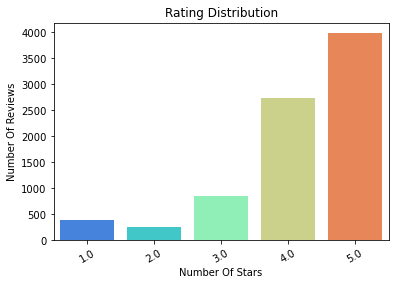

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(df1.rating.value_counts().sort_values(ascending=True).index,
                 y=df1.rating.value_counts().sort_values(ascending=True),palette="rainbow")
plt.title("Rating Distribution")
plt.xlabel("Number Of Stars")
plt.ylabel("Number Of Reviews")
plt.xticks(rotation=30)
plt.savefig("sent.jpeg",dpi=300,bbox_inches="tight")

In [21]:
df1 = df1[df1.rating!=3]

2021-10-14 20:36:46,262 : INFO : NumExpr defaulting to 8 threads.


In [22]:
import numpy as np
df1['sentiment'] = np.where(df1['rating'] >= 4, 'positive', 'negative')

In [23]:
df1.sentiment.value_counts(normalize=True)

positive    0.912524
negative    0.087476
Name: sentiment, dtype: float64

In [24]:
from wordcloud import STOPWORDS
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
s_words= list(stopwords.words('english'))
stop_words = list(STOPWORDS)+ ["what", "us", "this","well","there","much","us","and","you're","in","where","when","just","how","is","ha","re","are"
                              "hi","aren't", 'couldn','could','couldnt',"couldn't",'did','had','have','must','does','should','was',"it's"
                               "didn't", "doesn't", "don't", "hadn't", "hasn't", "haven't", "isn't", 'let', 'll',"may",'were','is','has','must',
                               'mustn', 'rt', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn','realli','now','got','man','people','a',
                               'becaus','caus',"one","im","guy","someone","two","nearby","i","he's","she's","we","it","they","wouldn’t","i've",
                               'aren', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'sdidn', 've',"will","restaurant"]



def remove_stopwords(txt):
    
    sentence = []
    s = ""
    for word in txt.split():    
        if(word not in stop_words):      
            sentence.append(word)
            s = ' '.join(sentence)
    return s

df1.comments = df1.comments.map(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dunga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
nltk.download("wordnet")
def lem_words(text):
    
    return " ".join([lemm.lemmatize(word) for word in text.split()])
    


df1.comments = df1.comments.apply(lambda metin: lem_words(metin))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dunga\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [26]:
df1.summary = df1.summary.fillna("")
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7362 entries, 0 to 8211
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       7362 non-null   object 
 1   rating     7362 non-null   float64
 2   comments   7362 non-null   object 
 3   users      7362 non-null   object 
 4   summary    7362 non-null   object 
 5   info       7362 non-null   object 
 6   street     7362 non-null   object 
 7   postCode   7362 non-null   object 
 8   sentiment  7362 non-null   object 
dtypes: float64(1), object(8)
memory usage: 575.2+ KB


In [27]:
import re
import string

alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())


df1.summary = df1.summary.map(alphanumeric).map(punc_lower)
df1.comments = df1.comments.map(alphanumeric).map(punc_lower)

In [28]:
def remove_url(txt):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',txt)

def remove_html(txt):
    html=re.compile(r'<.*?>')
    return html.sub(r'',txt)

# U+1F970
def remove_emoji(txt):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', txt)
def remove(emoji):
    em = re.compile(r"🥰")
    return em.sub(r"",emoji)
def remove_blank_space(text):
    return re.sub("\s\s+" , " ", text)
def remove_blank2(text):
    text = text.strip()
    return text
def remove_all(ReviewText):
    ReviewText = ReviewText.replace("(<br/>)", "")
    ReviewText = ReviewText.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.replace('(&amp)', '')
    ReviewText = ReviewText.replace('(&gt)', '')
    ReviewText = ReviewText.replace('(&lt)', '')
    ReviewText = ReviewText.replace('(\xa0)', ' ') 
    ReviewText = ReviewText.replace(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', ' ') 
    return ReviewText

    
df1.comments = df1.comments.apply(remove_url)
df1.comments = df1.comments.apply(remove_html)
df1.comments = df1.comments.apply(remove_emoji)
df1.comments = df1.comments.apply(remove)
df1.comments = df1.comments.apply(remove_blank_space)
df1.comments = df1.comments.apply(remove_blank2)
df1.comments = df1.comments.apply(remove_all)
df1.comments = df1.comments.map(remove_stopwords)
df1.comments[0]

'it’s every day experience star service coupled food best best chef jk jaskaran gujral team create exceptional experience truly immerse ambience feast mouthwatering delicacies menu enticing food absolutely delicious entrée main onto dessert flavour bold balanced perfectly corn tikki bharwaan aloo standouts aptly named dal makhani jk truly divine perfect place celebrate dad’s birthday surprise cake end meal cherry top kudos chef jk thank helping celebrate dad’s birthday giving wonderful experience thank back highly recommended'

--------Top 300 R - All Reviews-------------


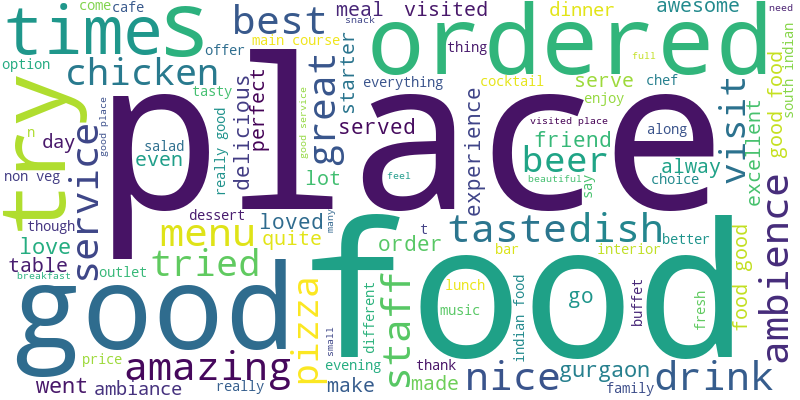

In [29]:
from wordcloud import WordCloud

txt = ','.join(list(df1.comments.values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white",stopwords = stop_words, 
                      min_font_size = 5, width=800, height=400, 
                      max_words=100, contour_width=3, contour_color='steelblue').generate(txt)

# Visualize the word cloud
print("--------Top 300 R - All Reviews-------------")
wordcloud.to_image()

In [30]:
wordcloud.to_file("a_reviews.png")

--------Negative Reviews-------------


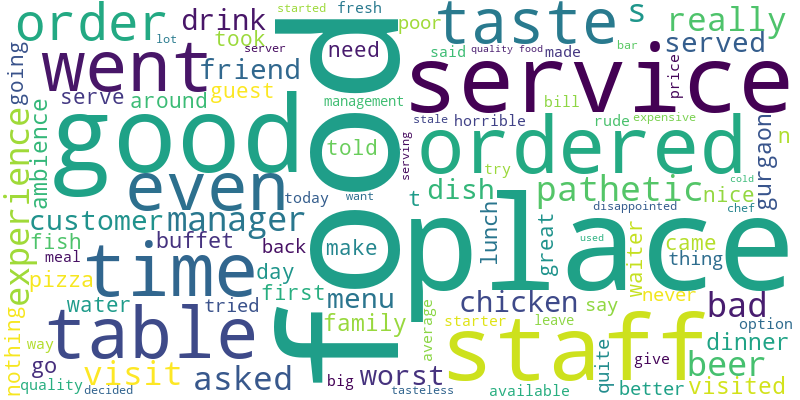

In [30]:
txt = ','.join(list(df1[df1.sentiment=="negative"].comments.values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white",stopwords = stop_words, 
                      min_font_size = 5, width=800, height=400, 
                      max_words=100, contour_width=3, contour_color='steelblue').generate(txt)
wordcloud.to_file("n_reviews.png")
# Visualize the word cloud
print("--------Negative Reviews-------------")
wordcloud.to_image()

--------Positive Reviews-------------


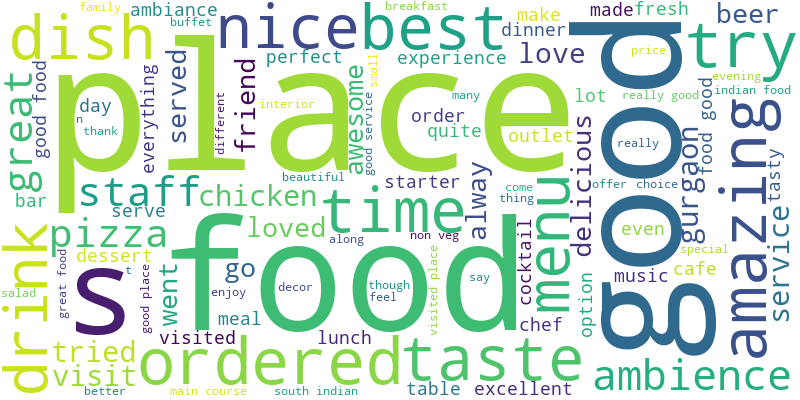

In [31]:

txt = ','.join(list(df1[df1.sentiment=="positive"].comments.values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white",stopwords = stop_words, 
                      min_font_size = 5, width=800, height=400, 
                      max_words=100, contour_width=3, contour_color='steelblue').generate(txt)

# Visualize the word cloud
print("--------Positive Reviews-------------")
wordcloud.to_image()

In [33]:
wordcloud.to_file("positive_reviews.png")

In [32]:
stopw = stop_words + ["food","dinner","menu","service","staff","starter","place","meal","lunch","drink","restaurant","burger","pub",
              "waiter","family","wine","main","bar","eat","area","evening","pizza","came","went","made","dessert","breakfast",
              "cocktail","table","booked","london","way","many","think","another","took","pasta","fish","dish","pay","going",
              "dessert","wife","came","go","say"]

In [33]:
from collections import Counter
c = Counter()
for txt in df1.comments.values:
    for word in txt.split():
        c[word] += 1
#en sık kullanılan on kelime
c.most_common(10)

[('food', 5484),
 ('place', 4541),
 ('good', 3914),
 ('service', 2049),
 ('great', 1890),
 ('ambience', 1444),
 ('chicken', 1400),
 ('time', 1320),
 ('staff', 1282),
 ('amazing', 1252)]

In [34]:
set([w for (w, wc) in c.most_common()[:-29:-1]])

{'bongtail',
 'carribean',
 'citric',
 'crafty',
 'cyberhuh',
 'evenly',
 'higene',
 'inclined',
 'kernels',
 'lunchmore',
 'mashroom',
 'oftenmore',
 'puchhka',
 'rafta',
 'reverberates',
 'sleepy',
 'soluble',
 'stafff',
 'swankier',
 'swarm',
 'sworn',
 'textural',
 'that’ll',
 '🤤beet',
 '🤤mean',
 '🤤wild',
 '🤤🤤',
 '🤤🤤cz'}

--------Restaurant Information-------------


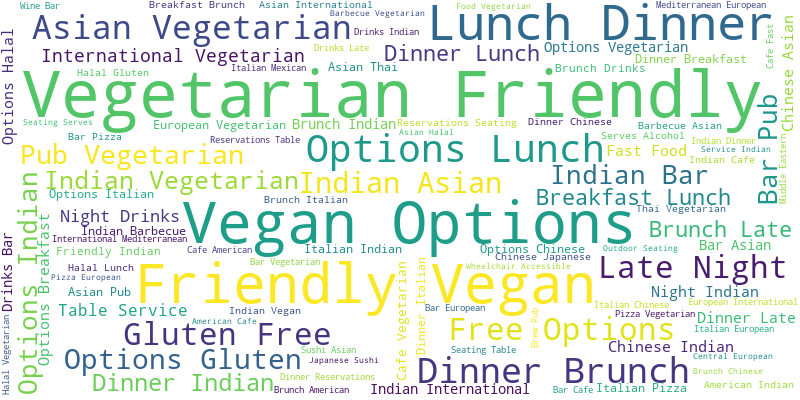

In [35]:
#stopwords2= stopwords+["TRY\\xa0"]

txt = ','.join(list(df1["info"].fillna(" ").values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white",stopwords = stop_words, 
                      min_font_size = 5, width=800, height=400, 
                      max_words=100, contour_width=3, contour_color='steelblue').generate(txt)
#wordcloud.to_file("restaurant_info.png")
# Visualize the word cloud
print("--------Restaurant Information-------------")
wordcloud.to_image()

In [36]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
def stem_words(text):

    return " ".join([stemmer.stem(word) for word in text.split()])
df1.comments = df1.comments.apply(lambda txt: stem_words(txt))


df1.comments[0]

'it everi day experi star servic coupl food best best chef jk jaskaran gujral team creat except experi truli immers ambienc feast mouthwat delicaci menu entic food absolut delici entré main onto dessert flavour bold balanc perfect corn tikki bharwaan aloo standout apt name dal makhani jk truli divin perfect place celebr dad birthday surpris cake end meal cherri top kudo chef jk thank help celebr dad birthday give wonder experi thank back high recommend'

In [37]:
from textblob import TextBlob
df1['polarity'] = df1['comments'].map(lambda text: TextBlob(text).sentiment.polarity)

mc = c.most_common(20)

df2 = pd.DataFrame(mc,columns=["word","freq"])
df2

word  freq
0         food  5484
1        place  4541
2         good  3914
3      service  2049
4        great  1890
5     ambience  1444
6      chicken  1400
7         time  1320
8        staff  1282
9      amazing  1252
10        nice  1245
11      really  1158
12       visit  1062
13     ordered  1041
14       taste   972
15        best   969
16         try   867
17  experience   863
18     gurgaon   816
19        beer   794

In [38]:
import plotly.express as px

fig = px.bar(df2, x='word', y='freq',
             hover_data=['word', 'freq'], color='freq',
             title='Most Common 20 Words',
             height=400)
fig.show()

In [39]:
df1["word count"] = df1.comments.str.len()

fig = px.histogram(df1, x="word count", nbins=200, title='Word Count')
fig.show()

In [40]:
fig = px.histogram(df1, x="polarity", nbins=20, title='Text Polarity')
fig.show()

In [41]:
df1.sentiment = df1.sentiment.map({"negative":0,"positive":1})
name_list = list(df1.groupby("name")["sentiment"].mean().sort_values(ascending=False).head(10).index)

In [42]:

df1.groupby("name")["polarity"].mean().sort_values(ascending=True).head(10)

name
 Saleem Javed Rule The Rolls          0.049447
 Butter Chicken Factory               0.053439
 The Potbelly Divine                  0.082740
 Drunk Art                            0.094280
 Cheesy Kneads                        0.108783
 Khan Chacha                          0.113120
 Tunday Kababi Dastarkhwan-e-Awadh    0.117013
 The Bowl Factory                     0.123142
 The G.T. Road                        0.125534
 The Noodle Company                   0.133419
Name: polarity, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(array([0, 1, 2, 3, 4]),
 [Text(0, 0, ' Gola Sizzlers'),
  Text(1, 0, ' Imperfecto'),
  Text(2, 0, " Berco's Gurugram"),
  Text(3, 0, ' Jungle Jamboree'),
  Text(4, 0, ' 0124 Bar Exchange')])

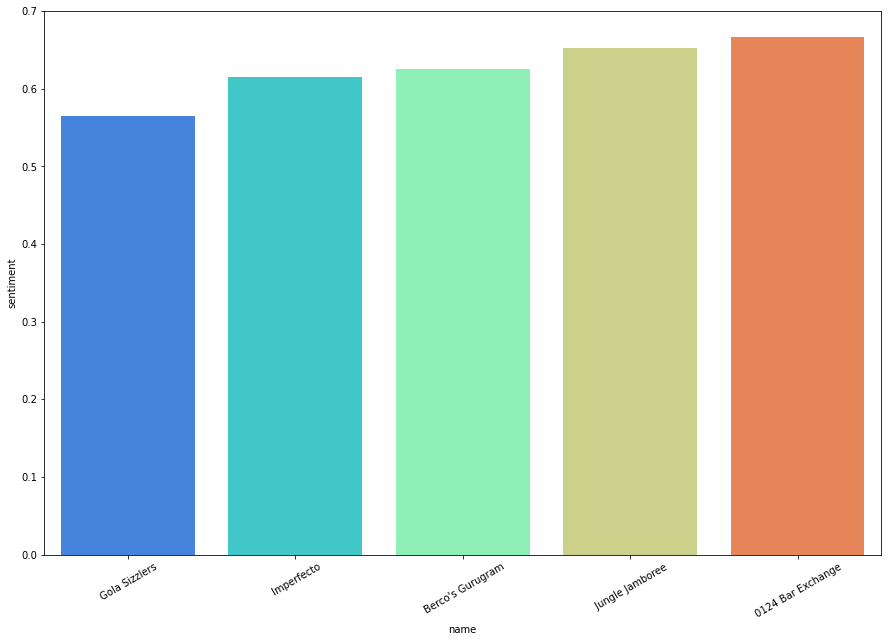

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
sns.barplot(df1.groupby("name")["sentiment"].mean().sort_values(ascending=True).head(5).index,
                 y=df1.groupby("name")["sentiment"].mean().sort_values(ascending=True).head(5),palette="rainbow")
plt.xticks(rotation=30)
#plt.savefig("sent.jpeg",dpi=300,bbox_inches="tight")

In [44]:
import plotly.express as px
fig = px.box(df1[df1.name.isin(name_list)], x="name",y='polarity', color="name",
             title="Polarity based On Restaurant Name",
             hover_data=["polarity"])
fig.show()

In [45]:

df1 = df1.drop(columns=["users"])
df1 = df1.drop_duplicates()

In [46]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7362 entries, 0 to 8211
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        7362 non-null   object 
 1   rating      7362 non-null   float64
 2   comments    7362 non-null   object 
 3   summary     7362 non-null   object 
 4   info        7362 non-null   object 
 5   street      7362 non-null   object 
 6   postCode    7362 non-null   object 
 7   sentiment   7362 non-null   int64  
 8   polarity    7362 non-null   float64
 9   word count  7362 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 632.7+ KB


In [47]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

def model_produce(X,y,model,min_df,ngram_range):
    m = model(stop_words=stopw, min_df=min_df,max_df=.85, token_pattern="\\b[a-z][a-z]+\\b",ngram_range=ngram_range)
    m2 = m.fit_transform(X)
    # modeldf = pd.DataFrame(m2.toarray(), columns=m.get_feature_names())
   # m3  = pd.concat([df1["polarity"],modeldf],axis=1)
    X_under, y_under = RandomUnderSampler(random_state=42).fit_sample(m2,y)
    X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=42,stratify = y_under)
  
    return X_train, X_test, y_train, y_test

In [48]:
from collections import Counter

X = df1.comments
y = df1.sentiment

model = TfidfVectorizer
ngram_range =(1,2)
X_train, X_test, y_train, y_test = model_produce(X,y,model,1,ngram_range)


Counter(y_train)

Counter({1: 451, 0: 450})

In [49]:
import eli5

In [50]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predict Negative', 'predict Positive'], 
                yticklabels=['actual Negative', 'actual Positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    print(cm_results)
    return cm_results

In [51]:
perform_list = []
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import time
kf = StratifiedKFold(n_splits=10, random_state=42,shuffle=True)
def calculate_metrics(model, X_train, X_test, y_train, y_test):
    begin = time.time()
    model.fit(X_train, y_train)
    now =time.time()
    y_pred = model.predict(X_test)
    test_accuracy = model.score(X_test, y_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(model)
    print('CV accuracy:', test_accuracy)
    print('Precision:{:6.4f},   Recall:{:6.4f}, F1:{:6.4f}'.format(precision, 
                                                                   recall, f1))
    cv_acc = cross_val_score(model, X_train, y_train, cv=kf,scoring="accuracy").mean()
    cv_f1 = cross_val_score(model, X_train, y_train, cv=kf,scoring="f1").mean()
    perform_list.append(dict([
            ("Model" , model.__class__.__name__),
            ("Time x 1000",(now-begin)*1000),
            ("Train Accuracy", model.score(X_train,y_train)),
            ("Test Accuracy", test_accuracy),
            ("Precision" , precision ),
            ("recall",recall),
            ("f1",f1),
            ("CV Accuracy",cv_acc),
            ("CV f1",cv_f1)]))

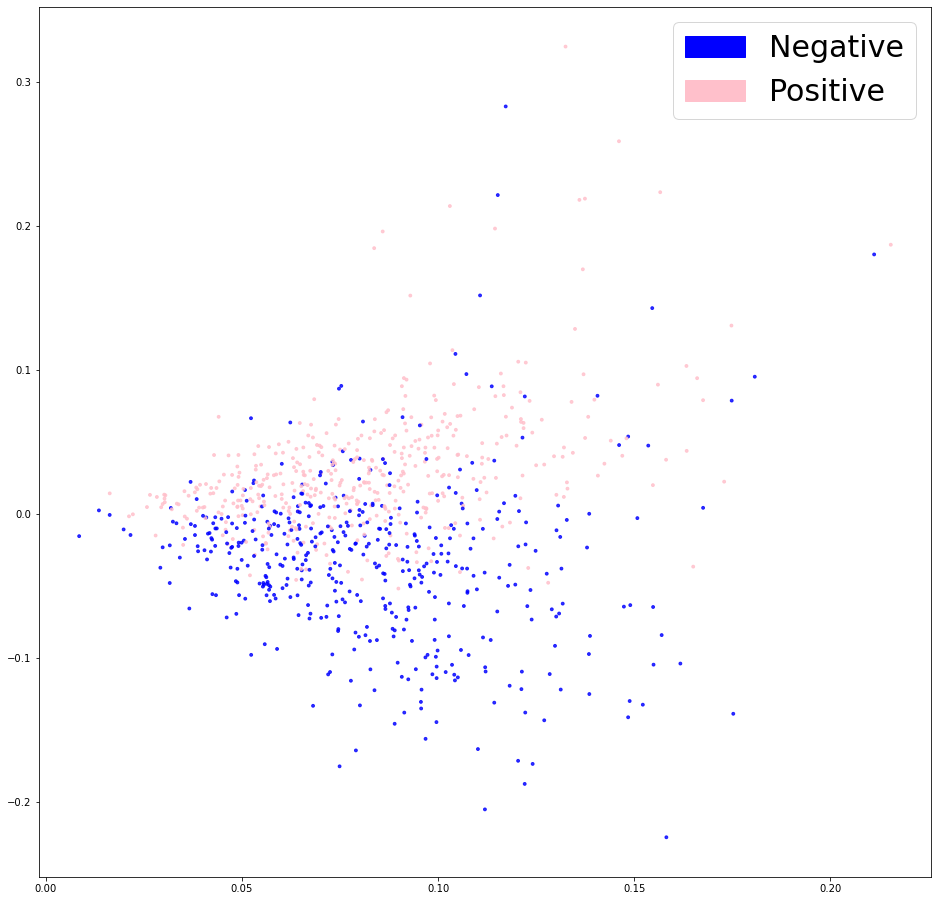

In [52]:
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['blue','pink','pink']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='blue', label='Negative')
            green_patch = mpatches.Patch(color='pink', label='Positive')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train, y_train)
plt.show()

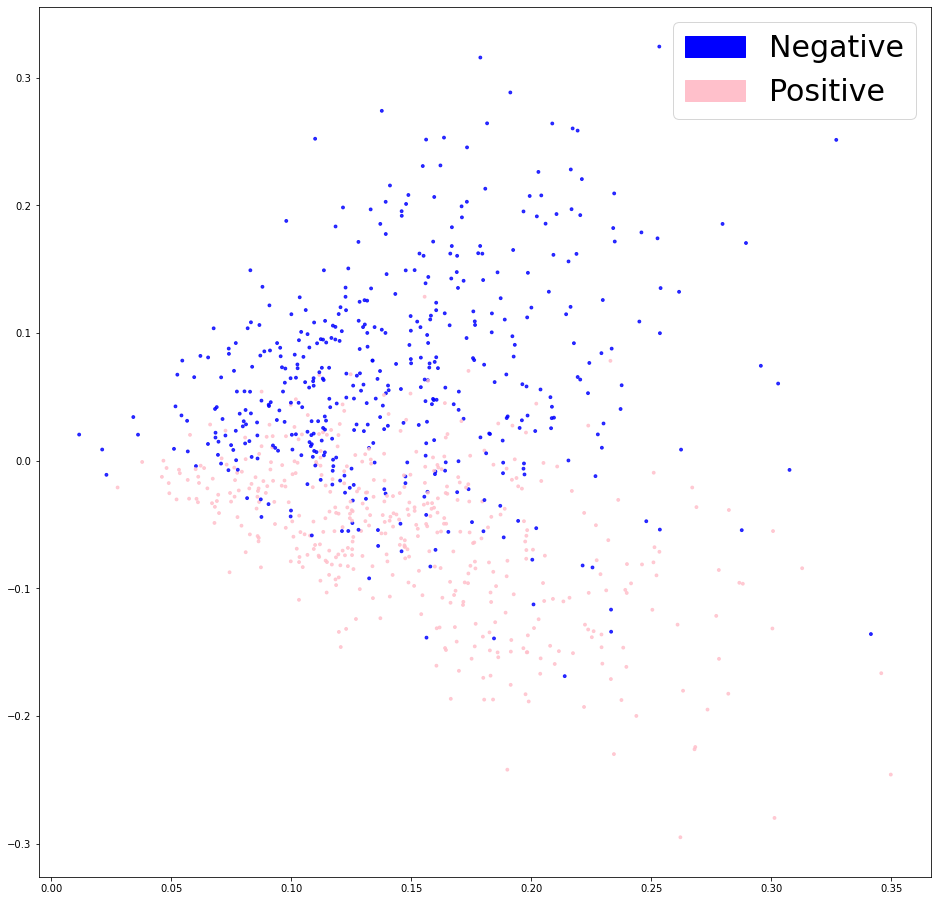

In [53]:
model = TfidfVectorizer
ngram_range = (1,1)

X_train2, X_test2, y_train2, y_test2  = model_produce(X,y,model,4,ngram_range)

fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train2, y_train2)
plt.show()

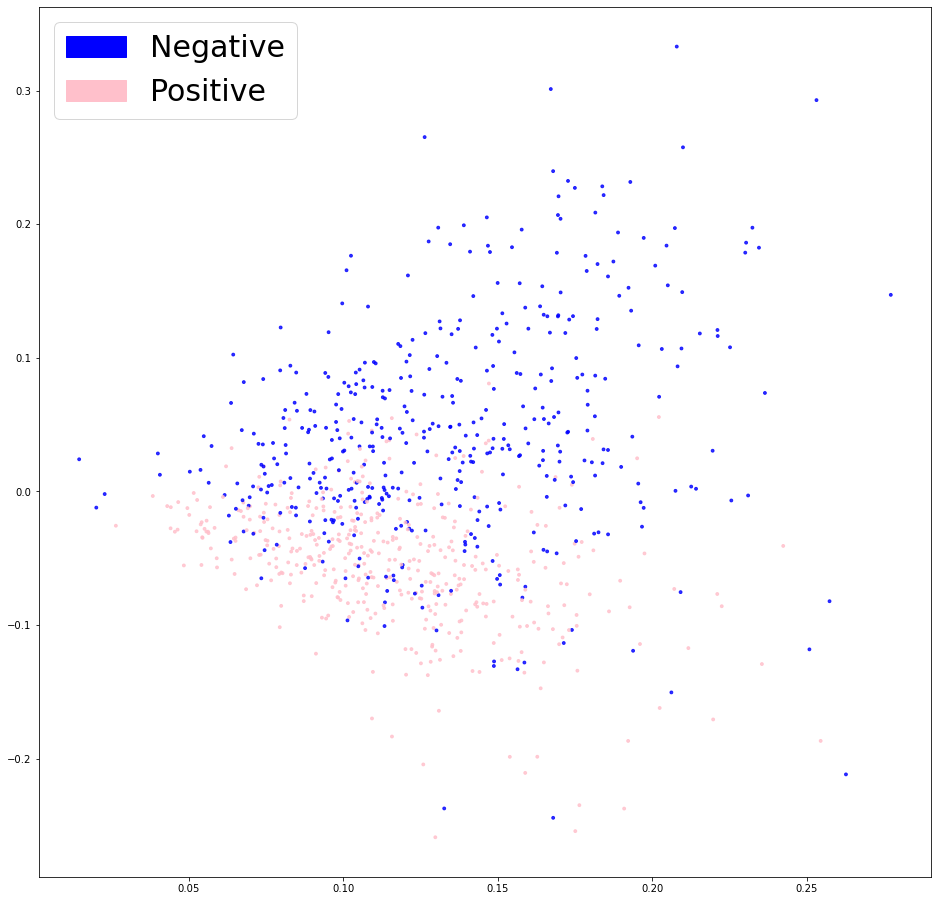

In [54]:
model = TfidfVectorizer
ngram_range =(1,2)


X_train3, X_test3, y_train3, y_test3  = model_produce(X,y,model,4,ngram_range)


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train3, y_train3)
plt.show() # biraz daha ayrıştı.

In [55]:
from sklearn.metrics import  precision_score, recall_score, precision_recall_curve,f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
perform_list = []
XGB = XGBClassifier()
GBC = GradientBoostingClassifier()
LR = LogisticRegression(solver='liblinear')
LR2 = LogisticRegression()
MNB = MultinomialNB()
RF = RandomForestClassifier()
BNB = BernoulliNB()
GNB = GaussianNB()
LSVC = LinearSVC()

models = [LR,GBC,MNB,BNB,RF,XGB,LSVC]


for model in models:
    calculate_metrics(model,X_train2, X_test2, y_train2, y_test2)
    print('------------------Model Result :---------------------')

LogisticRegression(solver='liblinear')
CV accuracy: 0.8708010335917312
Precision:0.8593,   Recall:0.8860, F1:0.8724
------------------Model Result :---------------------
GradientBoostingClassifier()
CV accuracy: 0.8449612403100775
Precision:0.8482,   Recall:0.8394, F1:0.8438
------------------Model Result :---------------------
MultinomialNB()
CV accuracy: 0.8863049095607235
Precision:0.8984,   Recall:0.8705, F1:0.8842
------------------Model Result :---------------------
BernoulliNB()
CV accuracy: 0.8837209302325582
Precision:0.8776,   Recall:0.8912, F1:0.8843
------------------Model Result :---------------------
RandomForestClassifier()
CV accuracy: 0.8604651162790697
Precision:0.8717,   Recall:0.8446, F1:0.8579
------------------Model Result :---------------------
[20:43:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'err

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
CV accuracy: 0.8682170542635659
Precision:0.8586,   Recall:0.8808, F1:0.8696
[20:43:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:43:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:43:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:43:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:43:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:43:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:43:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:43:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:43:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:43:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:43:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:43:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:43:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:43:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:43:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:43:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:43:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:43:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:43:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:43:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
------------------Model Result :---------------------
LinearSVC()
CV accuracy: 0.8837209302325582
Precision:0.8854,   Recall:0.8808, F1:0.8831
------------------Model Result :---------------------


In [56]:
per = pd.DataFrame(perform_list)
per = per[["Model","Time x 1000","Train Accuracy","Test Accuracy","Precision","recall","f1","CV Accuracy","CV f1"]]
per

Model  Time x 1000  Train Accuracy  Test Accuracy  \
0          LogisticRegression    10.002136        0.981132       0.870801   
1  GradientBoostingClassifier   695.830584        0.964484       0.844961   
2               MultinomialNB     2.003908        0.974473       0.886305   
3                 BernoulliNB     2.003431        0.972253       0.883721   
4      RandomForestClassifier   532.091141        1.000000       0.860465   
5               XGBClassifier   402.027130        0.997780       0.868217   
6                   LinearSVC     2.999067        1.000000       0.883721   

   Precision    recall        f1  CV Accuracy     CV f1  
0   0.859296  0.886010  0.872449     0.894603  0.895670  
1   0.848168  0.839378  0.843750     0.829158  0.828033  
2   0.898396  0.870466  0.884211     0.895665  0.896144  
3   0.877551  0.891192  0.884319     0.898999  0.900106  
4   0.871658  0.844560  0.857895     0.853626  0.861148  
5   0.858586  0.880829  0.869565     0.835800  0.835735  
6   0.885417  0.880829  0.883117     0.894591  0.894927

[0.871, 0.859, 0.886, 0.872]


[0.871, 0.859, 0.886, 0.872]

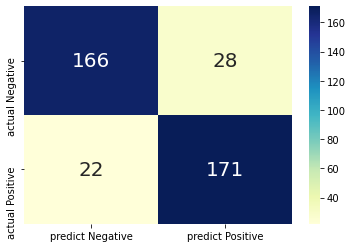

In [57]:

mb2 = LogisticRegression() # LogReg, Multi, Bernoulli
mb2.fit(X_train2, y_train2)

y_pred1 = mb2.predict(X_test2)

conf_matrix(y_test2,y_pred1)

[0.886, 0.898, 0.87, 0.884]


[0.886, 0.898, 0.87, 0.884]

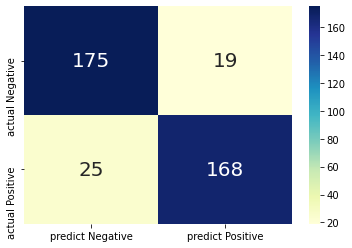

In [58]:
mb = MultinomialNB() # LogReg, Multi, Bernoulli
mb.fit(X_train2, y_train2)

y_pred1 = mb.predict(X_test2)

conf_matrix(y_test2,y_pred1)

In [59]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=10, random_state=42,shuffle=True)

import numpy as np

mnb = MultinomialNB()

parameters = {'alpha':np.linspace(0,9)}


clf2 = GridSearchCV(mnb, parameters, n_jobs=5, 
                   cv=kf,
                   scoring='accuracy',
                   refit=True)

clf2.fit(X_train2, y_train2)
clf2.best_params_

{'alpha': 6.244897959183674}

[0.886, 0.898, 0.87, 0.884]


[0.886, 0.898, 0.87, 0.884]

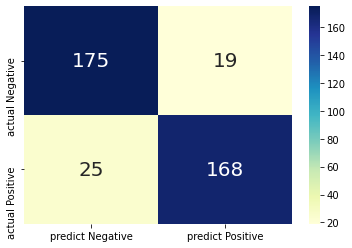

In [60]:
mnb = MultinomialNB(alpha = 2.2040816326530615)
mb.fit(X_train2, y_train2)

y_pred1 = mb.predict(X_test2)

conf_matrix(y_test2,y_pred1)

In [61]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

lr = LogisticRegression()

clf2 = GridSearchCV(lr, grid, n_jobs=5, 
                   cv=kf,
                   scoring='accuracy',
                   refit=True)

clf2.fit(X_train2, y_train2)
clf2.best_params_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning:

One or more of the test scores are non-finite: [       nan 0.66017094        nan 0.87797314        nan 0.87683761
        nan 0.89460317        nan 0.8968254         nan 0.89238095
        nan 0.88903541]



{'C': 10.0, 'penalty': 'l2'}

[0.868, 0.855, 0.886, 0.87]


[0.868, 0.855, 0.886, 0.87]

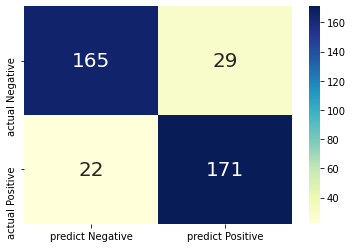

In [62]:
lr = LogisticRegression(C = 0.1, penalty = 'l2')
lr.fit(X_train2, y_train2)

y_pred1 = lr.predict(X_test2)

conf_matrix(y_test2,y_pred1)

In [63]:
plot_roc_curves()

NameError: name 'plot_roc_curves' is not defined

In [64]:

m = TfidfVectorizer(stop_words=stopw, min_df=4,max_df=.85, token_pattern="\\b[a-z][a-z]+\\b")
m2 = m.fit_transform(X)
modeldf = pd.DataFrame(m2.toarray(), columns=m.get_feature_names())
m3  = pd.concat([df1["polarity"],modeldf],axis=1)
X_under, y_under = RandomUnderSampler(random_state=42).fit_sample(m2,y)
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=42,stratify = y_under)

eli5.show_weights(lr, vec=m)

In [65]:
XGB = XGBClassifier()
GBC = GradientBoostingClassifier()
LR = LogisticRegression(solver='liblinear')
LR2 = LogisticRegression()
MNB = MultinomialNB()
RF = RandomForestClassifier()
BNB = BernoulliNB()
GNB = GaussianNB()
LSVC = LinearSVC()

models = [LR,GBC,MNB,BNB,RF,XGB,LSVC]


m = CountVectorizer(stop_words=stopw, min_df=4,max_df=.85, token_pattern="\\b[a-z][a-z]+\\b")
m2 = m.fit_transform(X)
X_under, y_under = RandomUnderSampler(random_state=42).fit_sample(m2,y)
X_trainc, X_testc, y_trainc, y_testc = train_test_split(X_under, y_under, test_size=0.3, random_state=42,stratify = y_under)




for model in models:
    calculate_metrics(model,X_trainc, X_testc, y_trainc, y_testc )
    print('------------------Model Result :---------------------')

LogisticRegression(solver='liblinear')
CV accuracy: 0.8785529715762274
Precision:0.8802,   Recall:0.8756, F1:0.8779
------------------Model Result :---------------------
GradientBoostingClassifier()
CV accuracy: 0.8475452196382429
Precision:0.8384,   Recall:0.8601, F1:0.8491
------------------Model Result :---------------------
MultinomialNB()
CV accuracy: 0.8863049095607235
Precision:0.8860,   Recall:0.8860, F1:0.8860
------------------Model Result :---------------------
BernoulliNB()
CV accuracy: 0.8837209302325582
Precision:0.8776,   Recall:0.8912, F1:0.8843
------------------Model Result :---------------------
RandomForestClassifier()
CV accuracy: 0.8604651162790697
Precision:0.8458,   Recall:0.8808, F1:0.8629
------------------Model Result :---------------------
[20:44:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'err

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
CV accuracy: 0.875968992248062
Precision:0.8643,   Recall:0.8912, F1:0.8776
[20:44:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:44:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:44:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:44:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:44:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:44:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:44:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:44:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:44:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:44:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:44:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:44:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:44:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:44:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:44:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:44:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:44:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:44:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:44:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:44:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
------------------Model Result :---------------------
LinearSVC()
CV accuracy: 0.8811369509043928
Precision:0.8657,   Recall:0.9016, F1:0.8832
------------------Model Result :---------------------


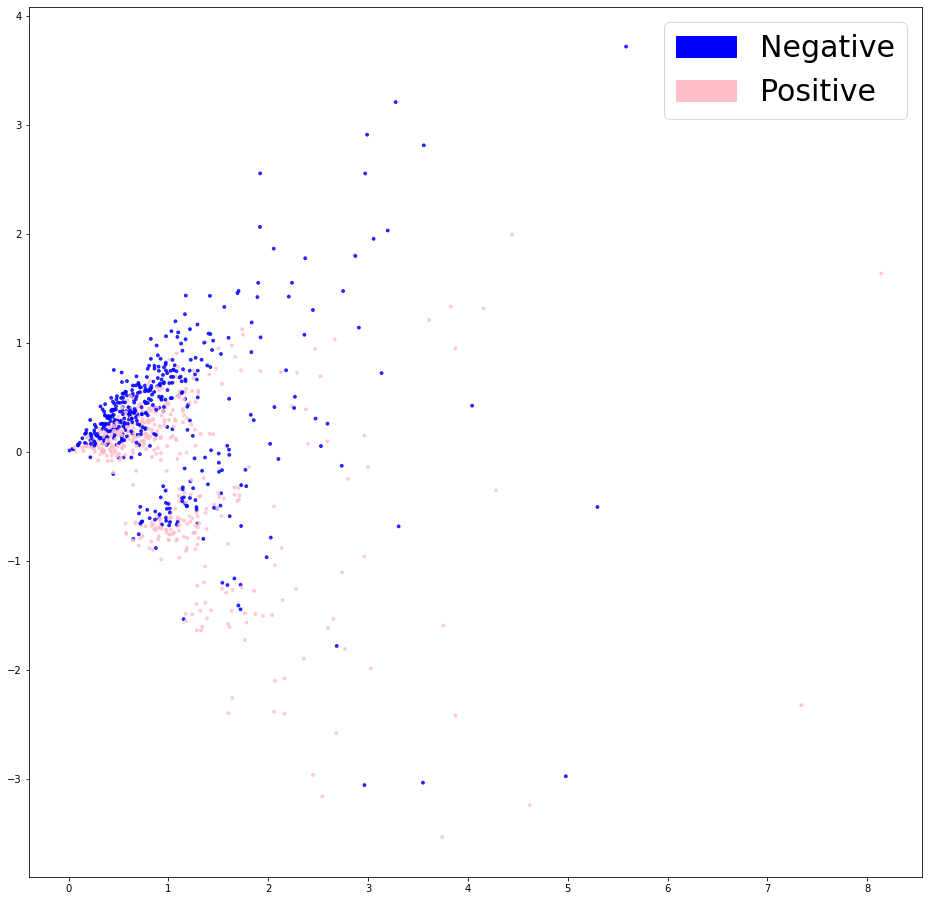

In [66]:

fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_trainc, y_trainc)
plt.show()

In [67]:
per2 = pd.DataFrame(perform_list)
per2 = per2[["Model","Time x 1000","Train Accuracy","Test Accuracy","Precision","recall","f1","CV Accuracy","CV f1"]]
per2

Model  Time x 1000  Train Accuracy  Test Accuracy  \
0           LogisticRegression    10.002136        0.981132       0.870801   
1   GradientBoostingClassifier   695.830584        0.964484       0.844961   
2                MultinomialNB     2.003908        0.974473       0.886305   
3                  BernoulliNB     2.003431        0.972253       0.883721   
4       RandomForestClassifier   532.091141        1.000000       0.860465   
5                XGBClassifier   402.027130        0.997780       0.868217   
6                    LinearSVC     2.999067        1.000000       0.883721   
7           LogisticRegression     6.999969        1.000000       0.878553   
8   GradientBoostingClassifier   567.043066        0.961154       0.847545   
9                MultinomialNB     0.999689        0.971143       0.886305   
10                 BernoulliNB     1.999855        0.972253       0.883721   
11      RandomForestClassifier   532.041311        1.000000       0.860465   
12               XGBClassifier   264.020205        0.990011       0.875969   
13                   LinearSVC     5.999088        1.000000       0.881137   

    Precision    recall        f1  CV Accuracy     CV f1  
0    0.859296  0.886010  0.872449     0.894603  0.895670  
1    0.848168  0.839378  0.843750     0.829158  0.828033  
2    0.898396  0.870466  0.884211     0.895665  0.896144  
3    0.877551  0.891192  0.884319     0.898999  0.900106  
4    0.871658  0.844560  0.857895     0.853626  0.861148  
5    0.858586  0.880829  0.869565     0.835800  0.835735  
6    0.885417  0.880829  0.883117     0.894591  0.894927  
7    0.880208  0.875648  0.877922     0.880208  0.879144  
8    0.838384  0.860104  0.849105     0.839158  0.828080  
9    0.886010  0.886010  0.886010     0.886789  0.888663  
10   0.877551  0.891192  0.884319     0.898999  0.900106  
11   0.845771  0.880829  0.862944     0.871343  0.863092  
12   0.864322  0.891192  0.877551     0.854652  0.854366  
13   0.865672  0.901554  0.883249     0.865775  0.865828

[0.886, 0.886, 0.886, 0.886]


[0.886, 0.886, 0.886, 0.886]

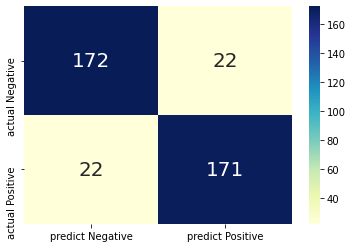

In [68]:

mb = MultinomialNB() # LogReg, Multi, Bernoulli
mb.fit(X_trainc, y_trainc)

y_pred1 = mb.predict(X_testc)

conf_matrix(y_testc,y_pred1)

In [69]:
mnb = MultinomialNB()

parameters = {'alpha':np.linspace(0.0001,9)}


clf2 = GridSearchCV(mnb, parameters, n_jobs=5, 
                   cv=kf,
                   scoring='accuracy',
                   refit=True)

clf2.fit(X_train2, y_train2)
clf2.best_params_

{'alpha': 6.244928571428571}

[0.886, 0.886, 0.886, 0.886]


[0.886, 0.886, 0.886, 0.886]

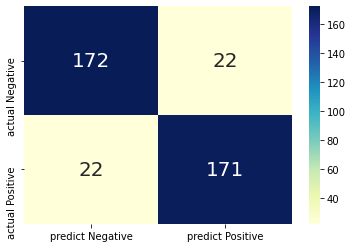

In [70]:
mnb = MultinomialNB(alpha = 2.204157142857143)
mnb.fit(X_trainc, y_trainc)

y_pred1 = mb.predict(X_testc)

conf_matrix(y_testc,y_pred1)

In [71]:
parameters = [{'alpha':np.linspace(0.1,1,10)}]


clf = GridSearchCV(BernoulliNB(), parameters, n_jobs=5, 
                   cv=kf,
                   scoring='accuracy',
                   refit=True)
clf.fit(X_trainc, y_trainc) # running the grid search
clf.best_params_

{'alpha': 1.0}

[0.871, 0.882, 0.855, 0.868]


[0.871, 0.882, 0.855, 0.868]

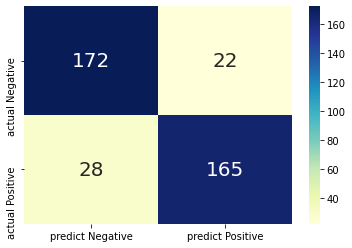

In [72]:
bnb = BernoulliNB(alpha = 0.30000000000000004)
bnb.fit(X_trainc, y_trainc)

y_pred1 = bnb.predict(X_testc)

conf_matrix(y_testc,y_pred1)

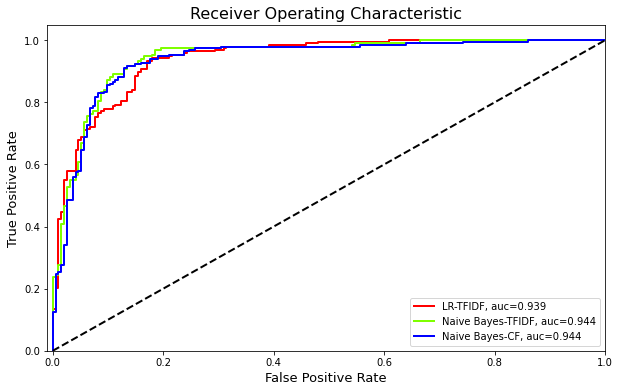

In [73]:
mb = MultinomialNB().fit(X_train2, y_train2)


y_pred1 = mb.predict(X_test2)

lr_proba = lr.predict_proba(X_test2)
nb_proba = mb.predict_proba(X_test2)
nb_proba2 = mnb.predict_proba(X_testc)
#l_propba = LSVC.predict_proba(X_test2)

def plot_roc_curves():
    plt.figure(figsize=(10,6))
    lw = 2    
    
    # Logistic Regression
    fpr, tpr, thresholds = roc_curve(y_test2, lr_proba[:,1], pos_label=1)
    auc_lr = roc_auc_score(y_test2, lr_proba[:,1])
    plt.plot(fpr, tpr, color='r',
             lw=lw, label='LR-TFIDF, auc=%.3f' % auc_lr)
         
    
    # Naive Bayes
    fpr, tpr, thresholds = roc_curve(y_test2, nb_proba[:,1], pos_label=1)
    auc_nbc = roc_auc_score(y_test2, nb_proba[:,1])
    plt.plot(fpr, tpr, color='chartreuse',
             lw=lw, label='Naive Bayes-TFIDF, auc=%.3f' % auc_nbc)

    # Naive Bayes 2
    fpr, tpr, thresholds = roc_curve(y_test2, nb_proba2[:,1], pos_label=1)
    auc_nb = roc_auc_score(y_testc, nb_proba2[:,1])
    plt.plot(fpr, tpr, color='b',
             lw=lw, label='Naive Bayes-CF, auc=%.3f' % auc_nbc)

    
    plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.title('Receiver Operating Characteristic', fontsize=16)
    plt.legend(loc="lower right")
    plt.show()
    #plt.savefig("roc.jpeg",dpi=300,bbox_inches="tight")
plot_roc_curves()

In [74]:
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

df.summary = df.summary.fillna("")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8212 entries, 0 to 8211
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      8212 non-null   object 
 1   rating    8212 non-null   float64
 2   comments  8212 non-null   object 
 3   users     8212 non-null   object 
 4   summary   8212 non-null   object 
 5   info      8212 non-null   object 
 6   street    8212 non-null   object 
 7   postCode  8212 non-null   object 
dtypes: float64(1), object(7)
memory usage: 513.4+ KB


In [75]:
rec = pd.DataFrame(df[["info","summary"]].astype("str").apply(lambda x: " ".join(x),axis=1),columns=["full"])
rec["name"] = df["name"]

rec = rec.drop_duplicates()
rec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264 entries, 0 to 8192
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   full    264 non-null    object
 1   name    264 non-null    object
dtypes: object(2)
memory usage: 6.2+ KB


In [76]:
all_comments = df.groupby("name",as_index=False).agg({"comments" : lambda x: " ".join(x)})
all_comments = all_comments.drop_duplicates()
all_comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252 entries, 0 to 251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      252 non-null    object
 1   comments  252 non-null    object
dtypes: object(2)
memory usage: 5.9+ KB


In [77]:
rec = pd.merge(rec, all_comments, how='inner')
rec.full = rec.full.fillna("")
rec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264 entries, 0 to 263
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   full      264 non-null    object
 1   name      264 non-null    object
 2   comments  264 non-null    object
dtypes: object(3)
memory usage: 8.2+ KB


In [78]:
rec = rec.drop_duplicates()
rec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264 entries, 0 to 263
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   full      264 non-null    object
 1   name      264 non-null    object
 2   comments  264 non-null    object
dtypes: object(3)
memory usage: 8.2+ KB


In [79]:
rc = pd.DataFrame(rec[["comments","full"]].astype("str").apply(lambda x: " ".join(x),axis=1),columns=["full"])
rc["name"] =rec["name"]

rc = rc.drop_duplicates()
rc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264 entries, 0 to 263
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   full    264 non-null    object
 1   name    264 non-null    object
dtypes: object(2)
memory usage: 6.2+ KB


In [80]:

rc = rc.drop_duplicates(subset=["name"])
rc["name"] =rec["name"]

rc.full.nunique()

252

In [81]:
tfidf_vec = TfidfVectorizer(stop_words="english",min_df=1,max_df=.85,ngram_range=(1, 3), token_pattern="\\b[a-z][a-z][a-z]+\\b")

# TfIdf matrix
matrix = tfidf_vec.fit_transform(rc.full)
# Compute the cosine similarity
cosine_sim = linear_kernel(matrix, matrix)

import pickle
with open('cosine_sim.pickle', 'wb') as handle:
    pickle.dump(cosine_sim, handle)

In [100]:
indices = pd.Series(rc.name)

In [101]:
indices

0                              Cafe G
1                       Biryani Blues
2             The Great Kabab Factory
3         Artusi Ristorante in Piazza
4       Cocktails & Dreams, Speakeasy
                    ...              
247                   The Bikers Cafe
248                        Brew Buddy
249                      Khaaja Chowk
250                          Italiano
251                            Raasta
Name: name, Length: 252, dtype: object

In [102]:

indices.to_csv("indices_gurugram.csv")

In [103]:
import pandas as pd
indices = pd.read_csv("indices_gurugram.csv")

indices = indices["name"]
indices

0                              Cafe G
1                       Biryani Blues
2             The Great Kabab Factory
3         Artusi Ristorante in Piazza
4       Cocktails & Dreams, Speakeasy
                    ...              
247                   The Bikers Cafe
248                        Brew Buddy
249                      Khaaja Chowk
250                          Italiano
251                            Raasta
Name: name, Length: 252, dtype: object

In [105]:
# rc = rc.reset_index()

def get_recommendation_gurugram(title, cosine_sim ,top_n):
    
    '''
    I choose the restaurant which is not null restaurant information
    '''    
    recommended_restaurant = []    
    # restaurant match indices
    idx = indices[indices == title].index[0]
    # similarity scores
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    # top n
    top_n_indexes = list(score_series.iloc[1:top_n+1].index)
    for i in top_n_indexes:
        recommended_restaurant.append(list(indices)[i])
        
    return recommended_restaurant

In [98]:
"indices.csv"

'indices.csv'

In [107]:
get_recommendation_gurugram(" Biryani Blues", cosine_sim ,5)

[' Biryani by Kilo', ' Nosh', ' Nayab Handi', ' Keralicious', " Wangshi's"]

In [108]:
rec[(rec["name"]=="1951. Cote Brasserie - Notting Hill") | (rec["name"]=="394. Gaucho Tower Bridge")| (rec["name"]=="2338. Zizzi - Tower Hill")]["full"]

Series([], Name: full, dtype: object)

In [109]:

# Just Reviews

rec = df.groupby("name",as_index=False).agg({"comments": lambda x: " ".join(x)})

rec.comments = rec.comments.map(remove_stopwords) 
rec.comments = rec.comments.apply(remove_blank_space)
rec.comments = rec.comments.apply(lambda metin: lem_words(metin))
rec.comments = rec.comments.apply(lambda metin: lem_words(metin))
rec.comments = rec.comments.map(alphanumeric).map(punc_lower)

In [110]:
rec = rec.reset_index()

tfidf_vec = TfidfVectorizer(stop_words="english",min_df=4,max_df=.85, token_pattern="\\b[a-z][a-z][a-z]+\\b")

# TfIdf matrix
matrix = tfidf_vec.fit_transform(rec.comments)
# Compute the cosine similarity
cosine_sim = linear_kernel(matrix, matrix)

In [113]:
indices = pd.Series(rec.name)

get_recommendation_gurugram(" Khaaja Chowk", cosine_sim ,5)

[' Daryaganj Restaurant (Ambience Mall)',
 ' Dana Choga',
 ' Friction The Drinkery',
 ' Pind Balluchi',
 ' Made in Punjab']